In [39]:
import numpy as np
from functools import partial
from collections.abc import Iterable
from pathlib import Path
from utils import bayesian_stats_course_tools
import astropy
import scipy
import dynesty
from matplotlib import pyplot as plt
from tqdm import tqdm
import corner 
import multiprocessing as mp


import zeus

random_gen = np.random.default_rng(seed=42)

# Set random seed for packages where we cant pass generator (i.e., zeus)
np.random.seed(42)

ctx = mp.get_context('fork')
n_cores = mp.cpu_count()

## Application: is the Universe flat?

As the Universe expands, photons lose energy: space expands, which causes the wave length of photons to increase.

Objects further away thus have their spectrum shifted to longer wave lengths: the cosmological redshift.

If we can measure the distance and redshift of an object, we can learn about how the Universe expands, from which we can infer how much dark energy there is, if the Universe is spatially flat, etc.



Here we want to find out if the Universe is better described by a model that assumes that the Universe is spatially flat or one that allows curvature.

Recall that we can use the Bayes' ratio to compare the probability of two models $M_1$ and $M_2$:
$$
    R = \frac{p(d | M_1)}{p(d | M_2)}
$$
With nested sampling we can compute the evidences $Z_1 = p(d | M_1)$ and $Z_2 = p(d | M_2)$.

One way to do this to look at Type Ia super novae: due to the astrophysical processes behind them, we know how bright they are intrinsically. This allows us to estimate the distance to a Type Ia super nova. This is a special property, usually we do not know how far objects are away!



Given a redshift $z$ and a cosmological model, we can compute the luminosity distance $d_L(z)$:
$$
d_L(z) = (1+z) c \int_0^z \frac{d z'}{H(z')}\,,
$$
where $c$ is the speed of light and
$$
H(z)^2 = H_0^2\left(\Omega_m(1+z)^3 + \Omega_\Lambda + (1-\Omega_m-\Omega_\Lambda)(1+z)^{-2}\right) \,.
$$
Here $H_0$ is the Hubble constant (the expansion rate of the Universe today), $\Omega_m$ the amount of matter in the Universe, and $\Omega_\Lambda$ the amount of dark energy.



For historical reasons, units in astronomy are weird. Instead of using the luminosity distance as the quantity to compare with data, we use the distance modulus $\mu(z)$:
$$
\mu(z) = 5\log_{10}\left(\frac{d_L(z)}{10\,\mathrm{pc}}\right) + M\,,
$$
where $M$ is a calibration parameter that we will marginalise over.


For the data we use the Pantheon sample (Brout+2022, https://arxiv.org/abs/2202.04077). This includes about 1500 Type Ia super novae and is the state-of-the-art data set fort this observation. We simplify our analysis a little bit here but the full setup is not that much more complicated.

The data are observations of the distance moduli $\hat{\mu_i}$ at redshfits $z_i$. The data are correlated, so we need a multivariate Gaussian likelihood:
$$
\vec{\hat{\mu}} \sim N(\vec{\mu}(\vec z), \Sigma)\,,
$$
where the $\vec{\mu}(\vec z)$ is the predicted distance modulus from the last slide.

In [2]:
from utils.likelihood import PantheonSH0ESLikelihood
data_path = Path("data")
# This holds the data and takes care of the modelling
pantheon_sh0es = PantheonSH0ESLikelihood(
    data_file_name=data_path / "pantheon_sh0es.npz",
    # data_file_name=data_path / "pantheon_sh0es_statonly_cov.npz",
)

# Pull out data for our simplified analysis
z_data = pantheon_sh0es.z_CMB
data = pantheon_sh0es.magnitude_data
data_error_bar = pantheon_sh0es.magnitude_data_error
inv_covariance = np.linalg.inv(pantheon_sh0es.covariance_no_calibrator)

In [3]:
cov = pantheon_sh0es.covariance_no_calibrator
cov

array([[ 0.02095099,  0.00122296,  0.00031219, ...,  0.00064715,
         0.00036431,  0.00025402],
       [ 0.00122296,  0.06038045,  0.00063897, ...,  0.00119537,
         0.00228407,  0.00280405],
       [ 0.00031219,  0.00063897,  0.03561398, ..., -0.00071156,
        -0.00051039, -0.00063602],
       ...,
       [ 0.00064715,  0.00119537, -0.00071156, ...,  0.04157373,
         0.00490226,  0.00588703],
       [ 0.00036431,  0.00228407, -0.00051039, ...,  0.00490226,
         0.06742823,  0.00875111],
       [ 0.00025402,  0.00280405, -0.00063602, ...,  0.00588703,
         0.00875111,  0.04499005]], dtype=float32)

In [4]:
cov = pantheon_sh0es.covariance_no_calibrator
cov

array([[ 0.02095099,  0.00122296,  0.00031219, ...,  0.00064715,
         0.00036431,  0.00025402],
       [ 0.00122296,  0.06038045,  0.00063897, ...,  0.00119537,
         0.00228407,  0.00280405],
       [ 0.00031219,  0.00063897,  0.03561398, ..., -0.00071156,
        -0.00051039, -0.00063602],
       ...,
       [ 0.00064715,  0.00119537, -0.00071156, ...,  0.04157373,
         0.00490226,  0.00588703],
       [ 0.00036431,  0.00228407, -0.00051039, ...,  0.00490226,
         0.06742823,  0.00875111],
       [ 0.00025402,  0.00280405, -0.00063602, ...,  0.00588703,
         0.00875111,  0.04499005]], dtype=float32)

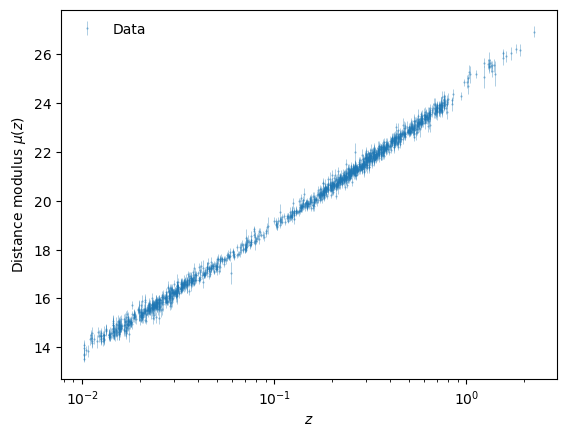

In [5]:
# And plot it
fig, ax = bayesian_stats_course_tools.analyse.plot_data(
    x=z_data, y=data, y_err=data_error_bar, axis_labels=["$z$", r"Distance modulus $\mu(z)$"],
    linestyle="none", marker=".", markersize=1, alpha=0.5, elinewidth=0.5,
)
ax.set_xscale("log")

Implement the physics model. We use the `astropy` library to compute the luminosity distance.

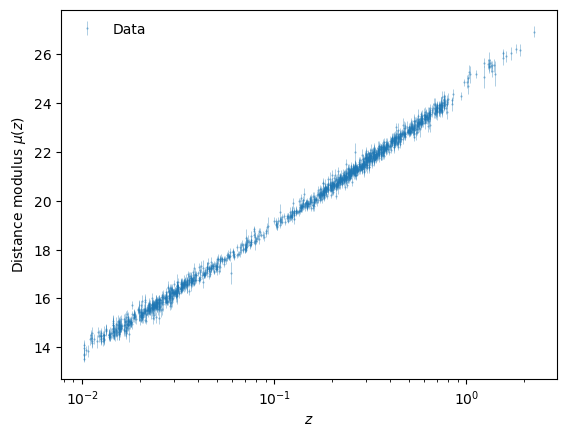

In [6]:
# And plot it
fig, ax = bayesian_stats_course_tools.analyse.plot_data(
    x=z_data, y=data, y_err=data_error_bar, axis_labels=["$z$", r"Distance modulus $\mu(z)$"],
    linestyle="none", marker=".", markersize=1, alpha=0.5, elinewidth=0.5,
)
ax.set_xscale("log")

In [7]:
def compute_distance_modulus(cosmology, z):
    luminosity_distance = cosmology.luminosity_distance(z)
    luminosity_distance = (luminosity_distance/astropy.units.Mpc).value

    mu = 5.0*np.log10(luminosity_distance*1e6/10)
    return mu

def LCDM_distance_modulus_model(theta, z):
    H_0, Omega_m, Omega_de, M = theta
    cosmology = astropy.cosmology.LambdaCDM(H0=H_0, Om0=Omega_m, Ode0=Omega_de)

    prediction = compute_distance_modulus(cosmology, z)
    prediction += M

    return prediction

We also look at another model where we assume the Universe is spatially flat. This is the case when $\Omega_m + \Omega_\Lambda = 1$. We then want to find out if the data prefer the general model or the flat model.

In [8]:
def flat_LCDM_distance_modulus_model(theta, z):
    H_0, Omega_m, M = theta
    cosmology = astropy.cosmology.FlatLambdaCDM(H0=H_0, Om0=Omega_m)

    prediction = compute_distance_modulus(cosmology, z)
    prediction += M

    return prediction

In [9]:
# # From the SH0ES analysis Riess+2022 (https://arxiv.org/abs/2112.04510)
H_0_prior = scipy.stats.norm(loc=73.04, scale=1.04)
# H_0_prior = scipy.stats.norm(loc=73.4, scale=1.04)

# scipy.stats.uniform defines the interval as [loc, loc+scale]
Omega_m_prior = scipy.stats.uniform(loc=0.1, scale=0.8)
Omega_de_prior = scipy.stats.uniform(loc=0.1, scale=0.8)
M_prior = scipy.stats.uniform(loc=-20, scale=2)

In [10]:
# From the SH0ES analysis Riess+2022 (https://arxiv.org/abs/2112.04510)
# H_0_prior = scipy.stats.norm(loc=73.04, scale=5)
# # H_0_prior = scipy.stats.uniform(loc=50, scale=50)

# # scipy.stats.uniform defines the interval as [loc, loc+scale]
# Omega_m_prior = scipy.stats.uniform(loc=0.1, scale=1)
# Omega_de_prior = scipy.stats.uniform(loc=0.1, scale=1)
# M_prior = scipy.stats.uniform(loc=-20, scale=4)

Finally the multivariate Gaussian likelihood.

In [11]:
def make_likelihood(model):
    def log_likelihood(theta):
        r = data - model(theta, z=z_data)
        return -0.5 * r @ inv_covariance @ r
    
    L = np.linalg.cholesky(pantheon_sh0es.covariance_no_calibrator)

    def sample_from_likelihood(theta):
        # scipy.stats.multivariate_normal is VERY slow for the 
        # large covariance we have, so we sample it ourselves
        mu = model(theta, z=z_data)
        sample = L @ random_gen.normal(size=mu.size) + mu
        return sample
    
    return log_likelihood, sample_from_likelihood

In [12]:
pantheon_sh0es.covariance_no_calibrator

array([[ 0.02095099,  0.00122296,  0.00031219, ...,  0.00064715,
         0.00036431,  0.00025402],
       [ 0.00122296,  0.06038045,  0.00063897, ...,  0.00119537,
         0.00228407,  0.00280405],
       [ 0.00031219,  0.00063897,  0.03561398, ..., -0.00071156,
        -0.00051039, -0.00063602],
       ...,
       [ 0.00064715,  0.00119537, -0.00071156, ...,  0.04157373,
         0.00490226,  0.00588703],
       [ 0.00036431,  0.00228407, -0.00051039, ...,  0.00490226,
         0.06742823,  0.00875111],
       [ 0.00025402,  0.00280405, -0.00063602, ...,  0.00588703,
         0.00875111,  0.04499005]], dtype=float32)

In [13]:
log_likelihood_LCDM, sample_from_likelihood_LCDM = make_likelihood(LCDM_distance_modulus_model)

def log_prior_lcdm(theta):
    H_0, Omega_m, Omega_de, M = theta
    return H_0_prior.logpdf(H_0) + Omega_m_prior.logpdf(Omega_m) + Omega_de_prior.logpdf(Omega_de) + M_prior.logpdf(M)

def log_posterior_lcdm(theta):
    p = log_prior_lcdm(theta)
    if not np.isfinite(p):
        return -np.inf
    return log_likelihood_LCDM(theta) + p

theta_init_lcdm = np.array([80.0, 0.2, 0.5, -19.5])

MAP_result = scipy.optimize.minimize(
    fun=lambda theta: -log_posterior_lcdm(theta),
    x0=theta_init_lcdm,
    method="Nelder-Mead",
)
theta_MAP_lcdm = MAP_result.x

In [14]:
log_likelihood_flat_LCDM, sample_from_likelihood_flat_LCDM = make_likelihood(flat_LCDM_distance_modulus_model)

def log_prior_flat_lcdm(theta):
    H_0, Omega_m, M = theta
    return H_0_prior.logpdf(H_0) + Omega_m_prior.logpdf(Omega_m) + M_prior.logpdf(M)

def log_posterior_flat_lcdm(theta):
    p = log_prior_flat_lcdm(theta)
    if not np.isfinite(p):
        return -np.inf
    return log_likelihood_flat_LCDM(theta) + p

theta_init_flat_lcdm = np.array([80.0, 0.2, -19.5])

MAP_result = scipy.optimize.minimize(
    fun=lambda theta: -log_posterior_flat_lcdm(theta),
    x0=theta_init_flat_lcdm,
    method="Nelder-Mead",
)
theta_MAP_flat_lcdm = MAP_result.x


In [15]:
print("MAP results for flat model: ", theta_MAP_flat_lcdm)
print("MAP results for curved model: ", theta_MAP_lcdm)

MAP results for flat model:  [ 73.040035     0.33120115 -19.25964577]
MAP results for curved model:  [ 73.04002232   0.30438128   0.6276276  -19.25714503]


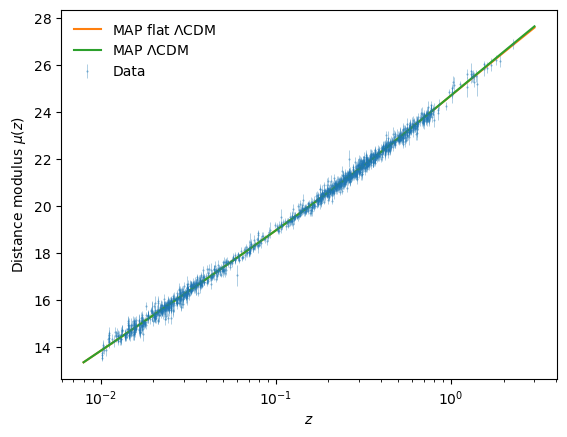

In [16]:
z_fine = np.geomspace(0.008, 3, 100)

fig, ax = bayesian_stats_course_tools.analyse.plot_data(
    x=z_data, y=data, y_err=data_error_bar, axis_labels=["$z$", r"Distance modulus $\mu(z)$"],
    linestyle="none", marker=".", markersize=1, alpha=0.5, elinewidth=0.5,
    models=[
        dict(x=z_fine, y=flat_LCDM_distance_modulus_model(theta=theta_MAP_flat_lcdm, z=z_fine), style={"label": r"MAP flat $\Lambda$CDM"}),
        dict(x=z_fine, y=LCDM_distance_modulus_model(theta=theta_MAP_lcdm, z=z_fine), style={"label": r"MAP $\Lambda$CDM"})
    ]
)
ax.set_xscale("log")
fig.savefig("plots/map.svg",format="svg")

Both models fit the data very well. Can we still say which one we should prefer?

Recall that we can use the Bayes' ratio to compare the probability of two models $M_1$ and $M_2$:
$$
    R = \frac{p(d | M_1)}{p(d | M_2)}
$$

With nested sampling we can compute the evidences $Z_1 = p(d | M_1)$ and $Z_2 = p(d | M_2)$.

Set up the priors for `dynesty`:

In [17]:
def prior_transform_flat_LCDM(u):
    x = np.array([
        H_0_prior.ppf(u[0]),
        Omega_m_prior.ppf(u[1]),
        M_prior.ppf(u[2])
    ])

    return x

def prior_transform_LCDM(u):
    x = np.array([
        H_0_prior.ppf(u[0]),
        Omega_m_prior.ppf(u[1]),
        Omega_de_prior.ppf(u[2]),
        M_prior.ppf(u[3])
    ])

    return x

And run `dynesty` to get estimates of the evidence. We get samples from the posterior as well during this.

In [332]:
def local_log_likelihood_flat_LCDM(theta):
    r = data - flat_LCDM_distance_modulus_model(theta, z=z_data)
    return -0.5 * r @ inv_covariance @ r

with ctx.Pool() as pool:
    sampler_flat_lcdm = dynesty.NestedSampler(
        loglikelihood=local_log_likelihood_flat_LCDM,
        prior_transform=prior_transform_flat_LCDM,
        ndim=3,
        nlive=2000,
        rstate=random_gen,
        pool=pool,
        queue_size=n_cores
    )
    sampler_flat_lcdm.run_nested(print_progress=True, dlogz=0.3)

sampler_flat_lcdm.results.summary()

18900it [03:18, 95.26it/s, +2000 | bound: 30 | nc: 1 | ncall: 160618 | eff(%): 13.176 | loglstar:   -inf < -720.843 <    inf | logz: -728.974 +/-  0.060 | dlogz:  0.000 >  0.300]

Summary
nlive: 2000
niter: 18900
ncall: 158618
eff(%): 13.176
logz: -728.974 +/-  0.103


In [333]:
def local_log_likelihood_LCDM(theta):
    r = data - LCDM_distance_modulus_model(theta, z=z_data)
    return -0.5 * r @ inv_covariance @ r

with ctx.Pool() as pool:
    sampler_lcdm = dynesty.NestedSampler(
        loglikelihood=local_log_likelihood_LCDM,
        prior_transform=prior_transform_LCDM,
        ndim=4,
        nlive=2000,
        rstate=random_gen,
        pool=pool,
        queue_size=n_cores
    )
    sampler_lcdm.run_nested(print_progress=True, dlogz=0.3)

sampler_lcdm.results.summary()

19912it [04:05, 51.71it/s, bound: 59 | nc: 24 | ncall: 249468 | eff(%):  7.982 | loglstar:   -inf < -721.374 <    inf | logz: -730.119 +/-  0.061 | dlogz:  0.458 >  0.300]   /Users/dschoess/Applications/miniconda3/envs/stats_course/lib/python3.13/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
20132it [04:17, 19.54it/s, bound: 63 | nc: 103 | ncall: 261353 | eff(%):  7.703 | loglstar:   -inf < -721.327 <    inf | logz: -730.088 +/-  0.061 | dlogz:  0.408 >  0.300]/Users/dschoess/Applications/miniconda3/envs/stats_course/lib/python3.13/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement fac

Summary
nlive: 2000
niter: 20720
ncall: 288382
eff(%):  7.878
logz: -729.786 +/-  0.107


To get an estimate of the uncertainty of the Bayes' ratio, we use a tool from `dynesty` to resample our runs to get a set of evidence estimates.

In [334]:
log_R = []
for i in range(500):
    log_z_flat_lcdm = dynesty.utils.jitter_run(sampler_flat_lcdm.results, rstate=random_gen).logz[-1]
    log_z_lcdm = dynesty.utils.jitter_run(sampler_lcdm.results, rstate=random_gen).logz[-1]
    log_R.append(log_z_flat_lcdm - log_z_lcdm)

log_R = np.array(log_R)

R_mean = np.mean(np.exp(log_R))
R_std = np.std(np.exp(log_R))
print(f"Bayes' ratio: {R_mean:.2f} ± {R_std:.2f}")

Bayes' ratio: 2.27 ± 0.19


# Comment

For some reason we are getting a very different value for the ratio compared to what he got in his code

# Things to do
## Mentioned specifically in lecture
- Prior predictive checks
- (adjust model -> probably not for us as he mentioned this is more for people with knowledge in astrology)
- Full posterior analysis
    - How do they look
- Perform model checks
    - Do model & likelihood actually predict the data
    - Are the fits good?

## Extracted from other parts of lecture
- Compare model fit
    - MAP, model predictive distr, posterior predictive distr (for example check lin_fits exercise solutions)
- Model checking
    - Chi-square
    - Posterior predictive distr checks (ppd_model_check function in the script)
- Model comparison
    - DIC, WAIC, cross-validation


## Write paper
- Potentially have chapter on importance of proper prior selection

## Model checking

### Chi square

In [18]:
y_err = data_error_bar
x=z_data
y=data

In [19]:
n_data = len(data)
n_param_flat_lcdm = 3
n_param_lcdm = 4

# Get the chi-squared statistics from the Gaussian log likelihood
chi_squared_flat_lcdm = -2*log_likelihood_flat_LCDM(theta_MAP_flat_lcdm)
chi_squared_lcdm = -2*log_likelihood_LCDM(theta_MAP_lcdm)

# Compute the PTE using the survival function
PTE_flat_lcdm = scipy.stats.chi2(
    df=n_data - n_param_flat_lcdm).sf(chi_squared_flat_lcdm)

PTE_lcdm = scipy.stats.chi2(
    df=n_data - n_param_lcdm).sf(chi_squared_lcdm)

print(f"Flat LCDM: χ²={chi_squared_flat_lcdm:.2f}, "
      f"ndof={n_data}-{n_param_flat_lcdm}, PTE={PTE_flat_lcdm:.3f}")

print(f"LCDM: χ²={chi_squared_lcdm:.2f}, "
      f"ndof={n_data}-{n_param_lcdm}, PTE={PTE_lcdm:.3f}")

Flat LCDM: χ²=1441.69, ndof=1580-3, PTE=0.993
LCDM: χ²=1441.41, ndof=1580-4, PTE=0.993


# Ensure the number of parameters is correct

### Posterior predictive checks

In [20]:
theta_MAP_lcdm

array([ 73.04002232,   0.30438128,   0.6276276 , -19.25714503])

In [21]:
n_param = 4
n_walker = 24
n_step = 3000

start_point = random_gen.normal(
    size=(n_walker, n_param),
    loc=theta_MAP_lcdm,
    scale=(0.1, 0.01, 0.01, 0.1)
)

with ctx.Pool() as pool:
    sampler_lcdm = zeus.EnsembleSampler(
        nwalkers=n_walker, ndim=n_param,
        logprob_fn=log_posterior_lcdm,
        pool=pool
    )
    sampler_lcdm.run_mcmc(start=start_point, nsteps=n_step, progress=True)

Initialising ensemble of 24 walkers...
Sampling progress : 100%|██████████| 3000/3000 [05:26<00:00,  9.18it/s]


In [37]:
print("Integrated autocorrelation time:")
auto_corr_times = []
for param_name, iat in zip(["H0", "Omega_m", "Omega_de", "M"],
                           zeus.AutoCorrTime(sampler_lcdm.get_chain())):
    print(f"{param_name}: {iat:.2f}")
    auto_corr_times.append(iat)

max_autocorr = int(np.ceil(max(auto_corr_times)))
print(f"Discard first {max_autocorr} steps.")
chain_lcdm = sampler_lcdm.get_chain(discard=300, flat=True, thin=10)

Integrated autocorrelation time:
H0: 7.40
Omega_m: 7.26
Omega_de: 7.03
M: 7.37
Discard first 8 steps.


In [23]:
n_param = 3
n_walker = 24
n_step = 3000

start_point = random_gen.normal(size=(n_walker, n_param), loc=theta_MAP_flat_lcdm, scale=(0.1, 0.01, 0.1))
with ctx.Pool() as pool:
    sampler_flat_lcdm = zeus.EnsembleSampler(
        nwalkers=n_walker, 
        ndim=n_param, 
        logprob_fn=log_posterior_flat_lcdm, 
        pool=pool
    )
    sampler_flat_lcdm.run_mcmc(start=start_point, nsteps=n_step, progress=True)

print("Integrated autocorrelation time:", zeus.AutoCorrTime(sampler_flat_lcdm.get_chain()))

Initialising ensemble of 24 walkers...
Sampling progress : 100%|██████████| 3000/3000 [05:46<00:00,  8.67it/s]

Integrated autocorrelation time: [5.13601492 5.22477341 5.08034901]


In [38]:
to_discard = int(max(zeus.AutoCorrTime(sampler_flat_lcdm.get_chain()))*5)
print(f"Being discarded {to_discard}.")
chain_flat_lcdm = sampler_flat_lcdm.get_chain(discard=300, flat=True, thin=10)

Being discarded 26.


In [26]:
def test_statistic(data, mu):
    r = data - mu
    return r @ inv_covariance @ r

def process_sample_flat(p):
   t_rep = test_statistic(
       data=sample_from_likelihood_flat_LCDM(p),
       mu=flat_LCDM_distance_modulus_model(p, z_data)
   )
   t = test_statistic(
       data=data,
       mu=flat_LCDM_distance_modulus_model(p, z_data)
   )
   return t_rep, t

with ctx.Pool() as pool:
   results = pool.map(process_sample_flat, chain_flat_lcdm)
   
T_rep_flat_lcdm, T_flat_lcdm = zip(*results)
T_rep_flat_lcdm = np.array(T_rep_flat_lcdm)
T_flat_lcdm = np.array(T_flat_lcdm)

ppd_pte_flat_lcdm = (T_rep_flat_lcdm > T_flat_lcdm).sum()/T_rep_flat_lcdm.size

print(f"Flat LCDM PPD PTE: {ppd_pte_flat_lcdm:.3f}")

Flat LCDM PPD PTE: 0.989


In [278]:
# T_rep_lcdm = np.array([
#     test_statistic(
#         data=sample_from_likelihood_LCDM(p),
#         mu=LCDM_distance_modulus_model(p, z_data)
#     ) for p in chain_lcdm
# ])
# T_lcdm = np.array([
#     test_statistic(
#         data=data,
#         mu=LCDM_distance_modulus_model(p, z_data)
#     ) for p in chain_lcdm
# ])

# ppd_pte_lcdm = (T_rep_lcdm > T_lcdm).sum()/T_rep_lcdm.size

# print(f"LCDM PPD PTE: {ppd_pte_lcdm:.3f}")

In [27]:
def process_sample_curved(p):
   t_rep = test_statistic(
       data=sample_from_likelihood_LCDM(p),
       mu=LCDM_distance_modulus_model(p, z_data)
   )
   t = test_statistic(
       data=data,
       mu=LCDM_distance_modulus_model(p, z_data)
   )
   return t_rep, t

with ctx.Pool() as pool:
   results = pool.map(process_sample_curved, chain_lcdm)
   
T_rep_curved_lcdm, T_curved_lcdm = zip(*results)
T_rep_curved_lcdm = np.array(T_rep_curved_lcdm)
T_curved_lcdm = np.array(T_curved_lcdm)

ppd_pte_curved_lcdm = (T_rep_curved_lcdm > T_curved_lcdm).sum()/T_rep_curved_lcdm.size

print(f"LCDM PPD PTE: {ppd_pte_curved_lcdm:.3f}")

LCDM PPD PTE: 0.989


In [28]:
def DIC(theta_star, theta_samples, log_likelihood):
    # Compute log likelihood at theta_star and the samples theta_i
    log_likelihood_star = log_likelihood(theta_star)
    log_likelihood_samples = np.array(
        [log_likelihood(theta) for theta in theta_samples]
    )
    p_D = 2*(log_likelihood_star - np.mean(log_likelihood_samples))
    p_V = 2*np.var(log_likelihood_samples)
    return -2*(log_likelihood_star - p_D), p_D, p_V

DIC_flat_lcdm, p_D_flat_lcdm, p_V_flat_lcdm = DIC(
    theta_star=theta_MAP_flat_lcdm,
    theta_samples=chain_flat_lcdm,
    log_likelihood=log_likelihood_flat_LCDM
)
DIC_lcdm, p_D_lcdm, p_V_lcdm = DIC(
    theta_star=theta_MAP_lcdm,
    theta_samples=chain_lcdm,
    log_likelihood=log_likelihood_LCDM
)

print(f"Flat LCDM: DIC = {DIC_flat_lcdm:.1f}, p_D = {p_D_flat_lcdm:.1f}, "
      f"p_V = {p_V_flat_lcdm:.1f}")
print(f"LCDM: DIC = {DIC_lcdm:.1f}, p_D = {p_D_lcdm:.1f}, "
      f"p_V = {p_V_lcdm:.1f}")

Flat LCDM: DIC = 1445.7, p_D = 2.0, p_V = 2.1
LCDM: DIC = 1447.5, p_D = 3.1, p_V = 3.0


Flat LCDM PPD PTE: 0.993

In [29]:
# TODO: Look at function make gaussian likelihood components -> adapt it to multivariat gaussian

In [30]:
def piecewise_log_likelihood(model, theta, x, y, inv_cov):
    r = y - model(theta, z=x)
    return -0.5 * r * inv_cov * r

In [31]:
def WAIC(theta_samples, log_likelihood, model, y_partitions, x_partitions, inv_cov_partition):
    # Compute the log likelihood for each partition separately
    pointwise_log_likelihood_samples = np.array(
        [[log_likelihood(model, theta, x_partitions[i], y_partitions[i], inv_cov_partition[i][i])
            for i in range(len(y_partitions))] 
         for theta in tqdm(theta_samples)]
    )

    # Compute the lppd and p_waic for each partition
    lppd = np.log(np.mean(np.exp(pointwise_log_likelihood_samples), axis=0))
    p_waic = np.var(pointwise_log_likelihood_samples, axis=0)
    # Check if the any of the terms in p_waic are too large, which indicates
    # a problem
    if np.any(p_waic > 0.4):
        print(f"Warning: Var[log p(y_i|theta)] > 0.4 for data points "
              f"{np.argwhere(p_waic > 0.4)}. p_WAIC unreliable!")
    # Sum up the partitions
    lppd = np.sum(lppd)
    p_waic = np.sum(p_waic)

    return -2*(lppd - p_waic), p_waic, pointwise_log_likelihood_samples

WAIC_, p_WAIC, pointwise_log_likelihood_samples = WAIC(
    theta_samples=chain_lcdm[:100],
    log_likelihood=piecewise_log_likelihood,
    model=LCDM_distance_modulus_model,
    y_partitions=data,
    x_partitions=z_data,
    inv_cov_partition=inv_covariance
)

WAIC_flat, p_WAIC_flat, pointwise_log_likelihood_samples_flat = WAIC(
    theta_samples=chain_flat_lcdm[:100],
    log_likelihood=piecewise_log_likelihood,
    model=flat_LCDM_distance_modulus_model,
    y_partitions=data,
    x_partitions=z_data,
    inv_cov_partition=inv_covariance
)

100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


In [32]:
WAIC_, p_WAIC, WAIC_flat, p_WAIC_flat

(np.float64(1518.434775745123),
 np.float64(4.493461467504898),
 np.float64(1517.1235777676695),
 np.float64(2.9938737327847376))

# Plots

In [41]:
def get_model_posterior_predictive(chain, model, sample_from_likelihood):
    chain_samples = chain[random_gen.choice(chain.shape[0], size=200)]

    # Evaluate the model at the sample parameters
    model_predictive = np.array(
        [model(theta=sample, z=z_fine) for sample in chain_samples]
    )
    posterior_predictive = np.array(
        [sample_from_likelihood(theta=sample)
        for sample in chain_samples]
    )
    return model_predictive, posterior_predictive

def generate_predictive_plots(model, chain, sample_from_likelihood, MAP_estimates, plot_model_predictive=True, plot_posterior_predictive=True, plot_title=None):
    model_predictive, posterior_predictive = get_model_posterior_predictive(chain, model, sample_from_likelihood)

    fig, ax = bayesian_stats_course_tools.analyse.plot_data(
        x=z_data, y=data, y_err=data_error_bar, 
        axis_labels=["$z$", r"Distance modulus $\mu(z)$"],
        linestyle="none", marker=".", markersize=1, alpha=0.5, elinewidth=0.5,
    )

    # Plot best fit model
    # best_fit_model = model(MAP_estimates, z_data)
    best_fit_model_fine = model(MAP_estimates, z_fine)

    # Plot model predictive intervals
    if plot_model_predictive:
        model_quantiles = np.quantile(
            model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
        )
        ax.fill_between(z_fine, model_quantiles[1], model_quantiles[-2],
            alpha=0.5, color="C1", label="Model predictive")
        ax.fill_between(z_fine, model_quantiles[0], model_quantiles[-1],
            alpha=0.5, color="C1")

    # Add posterior predictive intervals
    if plot_posterior_predictive:
        posterior_quantiles = np.quantile(
            posterior_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
        )
        ax.fill_between(z_data, posterior_quantiles[1], posterior_quantiles[-2],
            alpha=0.3, color="C2", label="Posterior predictive")
        ax.fill_between(z_data, posterior_quantiles[0], posterior_quantiles[-1],
            alpha=0.3, color="C2")

    # Plot best fit line on top
    ax.plot(z_fine, best_fit_model_fine, 'red', label='MAP')

    _ = ax.legend()

    if plot_title:
        ax.set_title(plot_title)
    ax.set_xscale("log")

    return fig

### Predictive plots 
- Modeled after intro to bayes

#### Prior predictive checks

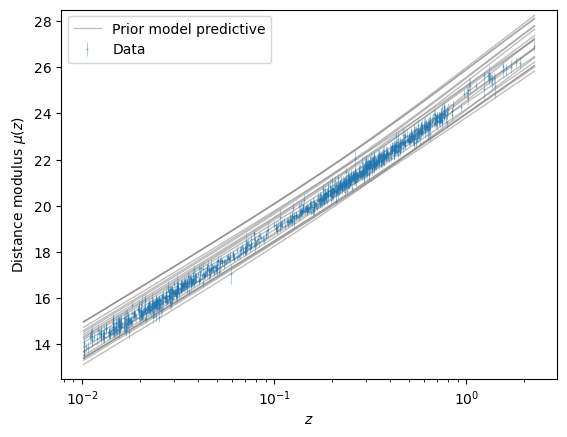

In [33]:
def plot_linear_data_set(x, y, y_err=None):
    """Plot linear data set and format the plot."""
    fig, ax = plt.subplots(1, 1)

    if y_err is not None:
        ax.errorbar(x, y, y_err, label="Data", linestyle="none", marker=".", markersize=1, alpha=0.5, elinewidth=0.5)
    else:
        ax.plot(x, y, marker=".", linestyle="none", label="Data")

    ax.set_xlabel("$z$")
    ax.set_ylabel(r"Distance modulus $\mu(z)$")
    ax.legend(loc="upper left")
    

    return fig, ax

def sample_prior_flat(n_sample):
    """Sample n_sample times from the prior distribution for the flat model."""
    return np.vstack((
        H_0_prior.rvs(n_sample, random_state=random_gen), 
        Omega_m_prior.rvs(n_sample, random_state=random_gen), 
        M_prior.rvs(n_sample, random_state=random_gen)
    )).T

def sample_prior_curved(n_sample):
    """Sample n_sample times from the prior distribution for the curved model."""
    return np.vstack((
        H_0_prior.rvs(n_sample, random_state=random_gen), 
        Omega_m_prior.rvs(n_sample, random_state=random_gen), 
        Omega_de_prior.rvs(n_sample, random_state=random_gen), 
        M_prior.rvs(n_sample, random_state=random_gen)
    )).T

# Evaluate the model at the prior sample parameters
prior_model_predictive_flat = np.array(
    [flat_LCDM_distance_modulus_model(thetas, z_data) for thetas in sample_prior_flat(n_sample=20)]
)

prior_flat, ax = plot_linear_data_set(x, y, y_err=data_error_bar)

style = dict(c="C7", lw=1, alpha=0.5)
ax.plot(z_data, prior_model_predictive_flat.T, **style)
ax.plot([], [], label="Prior model predictive", **style)
# ax.set_title("Flat ΛCDM Model Prior Predictions")
ax.set_xscale("log")
ax.legend()
ax.set_ylim(top=28.5, bottom=12.5)

prior_flat.savefig("plots/prior_flat.svg")

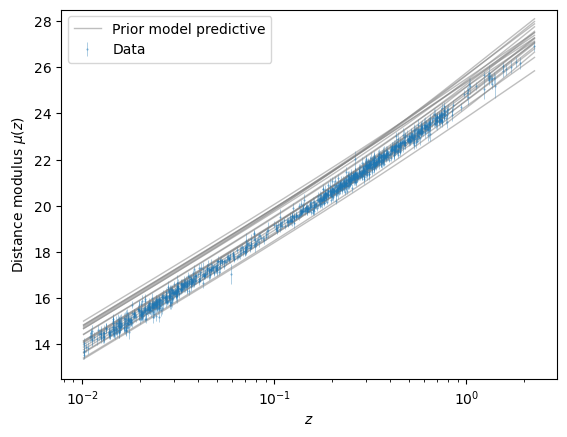

In [34]:
prior_model_predictive_curved = np.array(
    [LCDM_distance_modulus_model(thetas, z_data) for thetas in sample_prior_curved(n_sample=20)]
)

prior_curved, ax = plot_linear_data_set(x, y, y_err=data_error_bar)

ax.plot(z_data, prior_model_predictive_curved.T, **style)
ax.plot([], [], label="Prior model predictive", **style)
# ax.set_title("ΛCDM Model Prior Predictions")
ax.set_xscale("log")
ax.legend()
ax.set_ylim(top=28.5, bottom=12.5)

prior_curved.savefig("plots/prior_curved.svg")

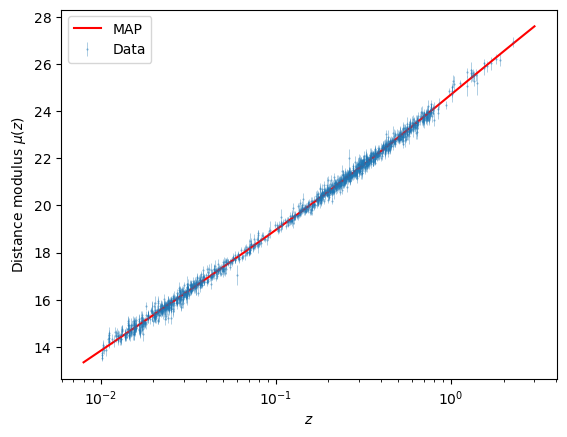

In [42]:
plot = generate_predictive_plots(
    model=flat_LCDM_distance_modulus_model, 
    chain=chain_flat_lcdm, 
    sample_from_likelihood=sample_from_likelihood_flat_LCDM, 
    MAP_estimates=theta_MAP_flat_lcdm, 
    # plot_title="Predictions Flat ΛCDM Model",
    plot_model_predictive=False,
    plot_posterior_predictive=False
)

#### Posterior and model predictive checks

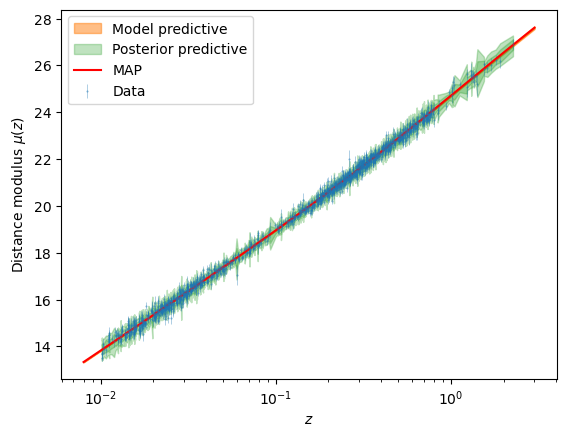

In [43]:
plot = generate_predictive_plots(
    model=flat_LCDM_distance_modulus_model, 
    chain=chain_flat_lcdm, 
    sample_from_likelihood=sample_from_likelihood_flat_LCDM, 
    MAP_estimates=theta_MAP_flat_lcdm, 
    # plot_title="Predictions Flat ΛCDM Model",
    plot_model_predictive=True,
    plot_posterior_predictive=True
)
plot.savefig("plots/predictive_flat.svg")

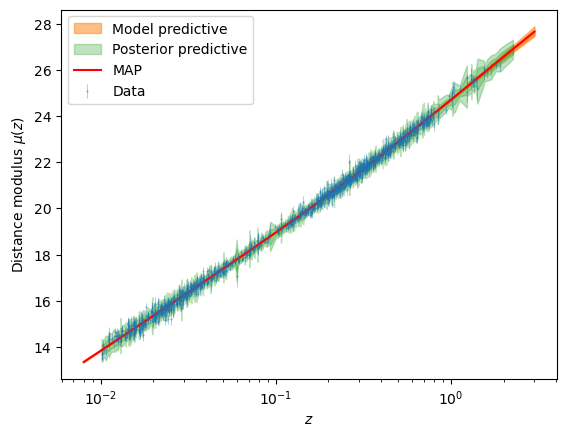

In [44]:
plot = generate_predictive_plots(
    model=LCDM_distance_modulus_model, 
    chain=chain_lcdm, 
    sample_from_likelihood=sample_from_likelihood_LCDM, 
    MAP_estimates=theta_MAP_lcdm, 
    # plot_title="Predictions ΛCDM Model"
)
plot.savefig("plots/predictive_curved.svg")

### Corner plots

In [45]:
def create_corner_plot(
    samples,
    param_labels,
    map_estimates,
    title=None,
    figsize=None,
):
    n_params = samples.shape[1]
    
    # Set default figure size if not provided
    if figsize is None:
        figsize = (3*n_params, 3*n_params)
    
    fig = plt.figure(figsize=figsize)
    
    # Create corner plot
    fig = corner.corner(
        samples,
        bins=20,
        color="C2",
        labels=param_labels,
        levels=1-np.exp(-0.5*np.array([1, 2])**2),  # 1σ and 2σ contours
        # quantiles=[0.025, 0.16, 0.84, 0.975],
        title_quantiles=[0.16, 0.5, 0.84],
        label_kwargs={"fontsize": 14},
        title_kwargs={"fontsize": 12},
        smooth=1,
        plot_datapoints=False,
        fill_contours=True,
        hist_kwargs={"density": True},
        labelpad=0.3,
        fig=fig
    )
    
    axes = np.array(fig.axes).reshape((n_params, n_params))
    
    legend_line = None
    
    for i in range(n_params):
        # Add vertical line to histogram
        axes[i,i].axvline(map_estimates[i], color='red', linestyle='--', lw=1.5, alpha=0.8)
        
        # Add lines to 2D plots
        for j in range(i):
            line_v = axes[i,j].axvline(map_estimates[j], color='red', linestyle='--', lw=1.5, alpha=0.5)
            line_h = axes[i,j].axhline(map_estimates[i], color='red', linestyle='--', lw=1.5, alpha=0.5)
            
            # Store one of the lines for the legend
            if legend_line is None:
                legend_line = line_v
    
    # Add legend to the figure (outside the plots)
    fig.legend([legend_line], 
            ['MAP'],  # Changed legend text from 'Mode' to 'MAP'
            fontsize=12,
            bbox_to_anchor=(0.55, 0.8),  # Position of the legend
            loc='upper right',  # Reference point for the bbox_to_anchor
            bbox_transform=fig.transFigure)

    # Adjust spacing - modified to leave space for legend
    plt.subplots_adjust(
        left=0.1,
        bottom=0.1,
        right=0.85,  # Reduced from 0.9 to make space for legend
        top=0.9,
        wspace=0.1,
        hspace=0.1
    )
    
    # Add title if provided
    if title:
        fig.suptitle(title, y=0.95, fontsize=16)
    
    return fig

Substituting symbol M from STIXNonUnicode
Substituting symbol M from STIXNonUnicode
Substituting symbol M from STIXNonUnicode
Substituting symbol M from STIXNonUnicode


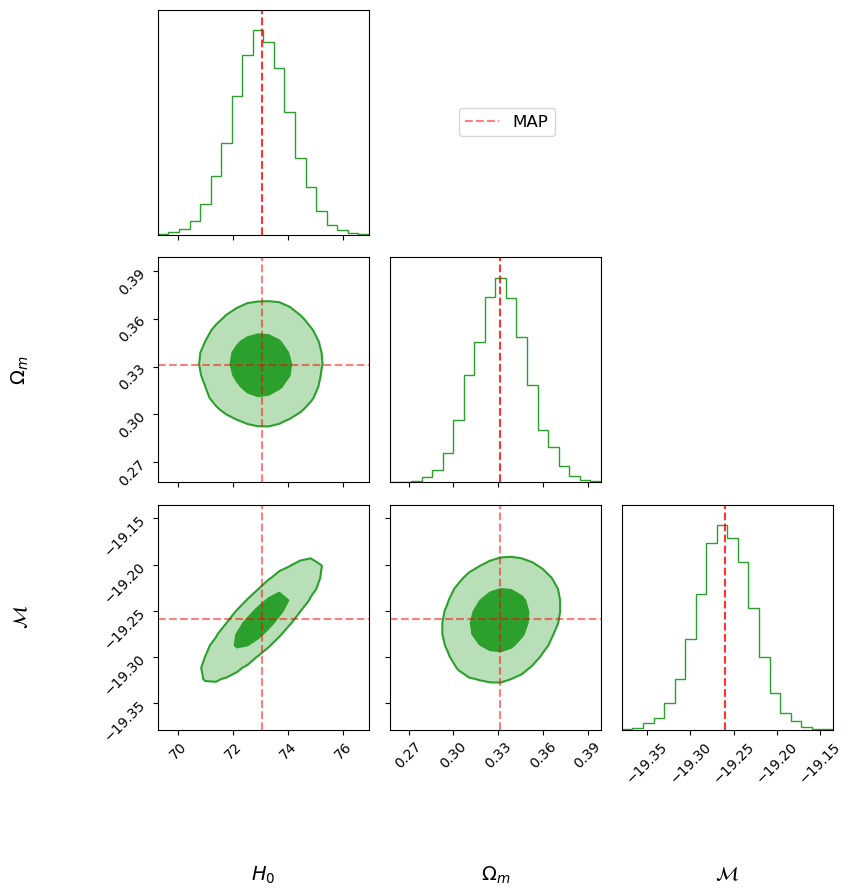

In [46]:
fig_flat_lcdm = create_corner_plot(
    samples=chain_flat_lcdm,
    param_labels= [r'$H_0$', r'$\Omega_m$', r'$\mathcal{M}$'],
    # title='Flat ΛCDM Model Parameters',
    map_estimates=theta_MAP_flat_lcdm
)
fig_flat_lcdm.savefig("plots/corner_flat.svg", bbox_inches='tight')

Substituting symbol M from STIXNonUnicode
Substituting symbol M from STIXNonUnicode
Substituting symbol M from STIXNonUnicode
Substituting symbol M from STIXNonUnicode


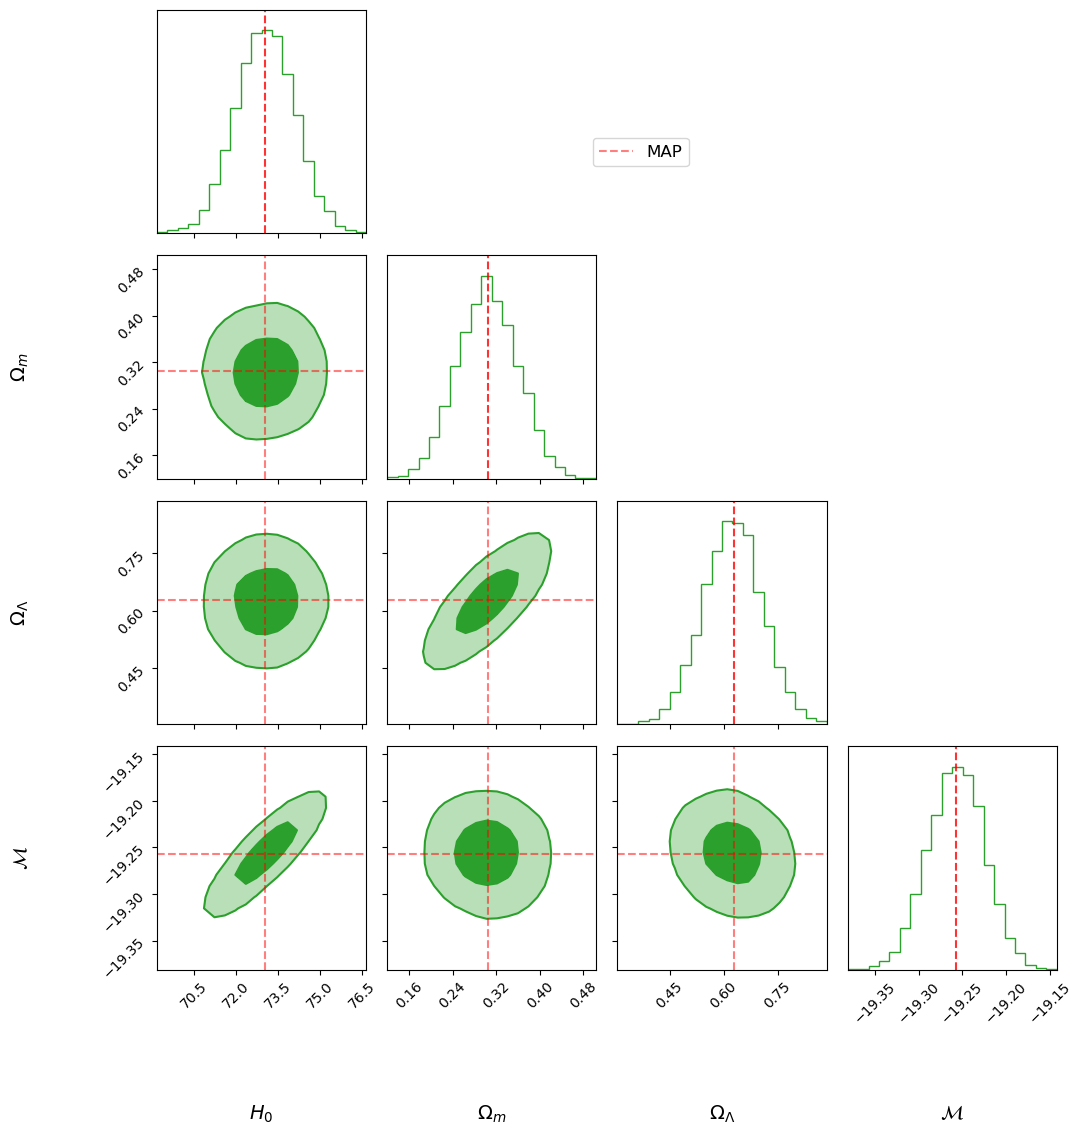

In [47]:
fig_curved_lcdm = create_corner_plot(
    samples=chain_lcdm,
    param_labels= [r'$H_0$', r'$\Omega_m$',r'$\Omega_{\Lambda}$', r'$\mathcal{M}$'],
    # title='ΛCDM Model Parameters',
    map_estimates=theta_MAP_lcdm
)
fig_curved_lcdm.savefig("plots/corner_curved.svg", bbox_inches='tight')

### Chain analysis

Trace plots

In [48]:
mean_flat, std_flat = chain_flat_lcdm.mean(axis=0), chain_flat_lcdm.std(axis=0)
mean_curved, std_curved = chain_lcdm.mean(axis=0), chain_lcdm.std(axis=0)
print("Flat: ")
print(f"H0: {mean_flat[0]} ± {std_flat[0]}")
print(f"Omaga_m: {mean_flat[1]} ± {std_flat[1]}")
print(f"M: {mean_flat[2]} ± {std_flat[2]}\n")

print("Curved")
print(f"H0: {mean_curved[0]} ± {std_curved[0]}")
print(f"Omaga_m: {mean_curved[1]} ± {std_curved[1]}")
print(f"Omaga_de: {mean_curved[2]} ± {std_curved[2]}")
print(f"M: {mean_curved[3]} ± {std_curved[3]}\n")

Flat: 
H0: 73.0302164560211 ± 1.0420500514381306
Omaga_m: 0.3317241141268975 ± 0.018271369848650895
M: -19.259994417767704 ± 0.0318633953356429

Curved
H0: 73.04069239843967 ± 1.045679698682114
Omaga_m: 0.3042528366505375 ± 0.05497719800092959
Omaga_de: 0.6250857997767877 ± 0.0818664870821467
M: -19.25698898577758 ± 0.032139912477801874



In [49]:
mean_flat, std_flat = chain_flat_lcdm.mean(axis=0), chain_flat_lcdm.std(axis=0)
mean_curved, std_curved = chain_lcdm.mean(axis=0), chain_lcdm.std(axis=0)
print("Flat: ")
print(f"H0: {mean_flat[0]} ± {std_flat[0]}")
print(f"Omaga_m: {mean_flat[1]} ± {std_flat[1]}")
print(f"M: {mean_flat[2]} ± {std_flat[2]}\n")

print("Curved")
print(f"H0: {mean_curved[0]} ± {std_curved[0]}")
print(f"Omaga_m: {mean_curved[1]} ± {std_curved[1]}")
print(f"Omaga_de: {mean_curved[2]} ± {std_curved[2]}")
print(f"M: {mean_curved[3]} ± {std_curved[3]}\n")

Flat: 
H0: 73.0302164560211 ± 1.0420500514381306
Omaga_m: 0.3317241141268975 ± 0.018271369848650895
M: -19.259994417767704 ± 0.0318633953356429

Curved
H0: 73.04069239843967 ± 1.045679698682114
Omaga_m: 0.3042528366505375 ± 0.05497719800092959
Omaga_de: 0.6250857997767877 ± 0.0818664870821467
M: -19.25698898577758 ± 0.032139912477801874



Substituting symbol M from STIXNonUnicode
Substituting symbol M from STIXNonUnicode
Substituting symbol M from STIXNonUnicode
Substituting symbol M from STIXNonUnicode
Substituting symbol M from STIXNonUnicode


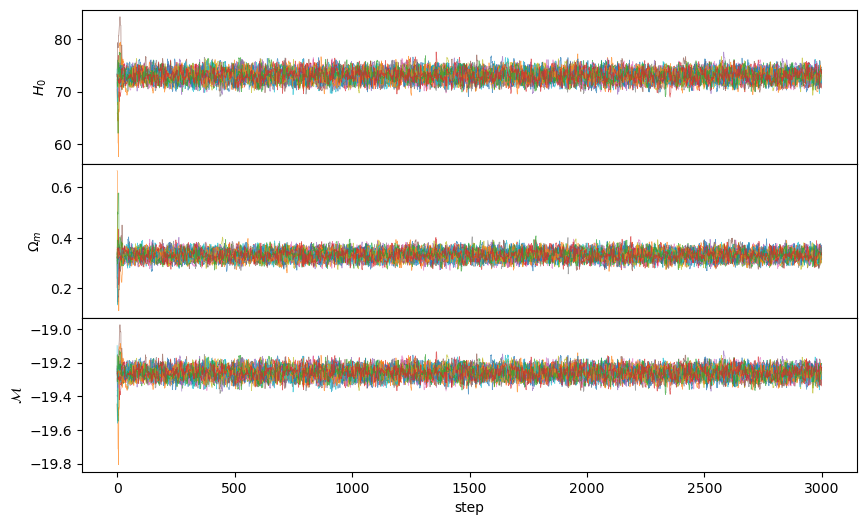

Substituting symbol M from STIXNonUnicode


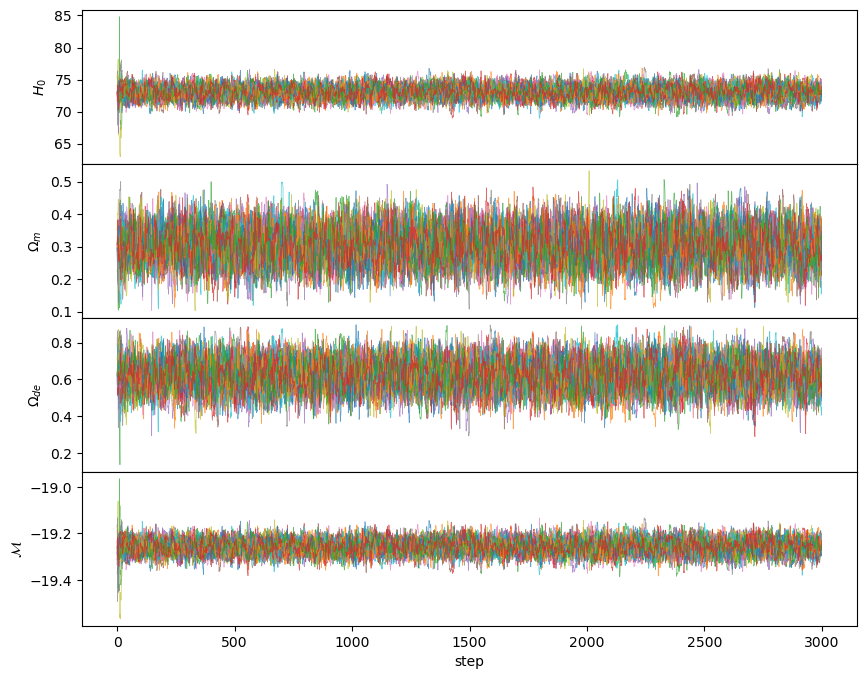

In [51]:
# def plot_chains(param_names, n_walker, chain_per_walker):
#     # Plot the tracer of the chain, this time for all the walkers
#     fig, ax = plt.subplots(len(param_names), 1, sharex=True)
#     plt.subplots_adjust(hspace=0)

#     for i, name in enumerate(param_names):
#         for j in range(n_walker):
#             ax[i].plot(chain_per_walker[:, j, i], lw=0.5, alpha=0.7, color=f"C{j}")
#         ax[i].set_ylabel(name)

#     ax[-1].set_xlabel("step")
#     return fig

def plot_chains(param_names, n_walker, chain_per_walker):
    # Calculate a suitable height based on number of parameters
    # Each parameter subplot gets 2 inches of height
    fig_height = len(param_names) * 2  
    
    # Create figure with custom size (width=10 is a reasonable default)
    fig, ax = plt.subplots(len(param_names), 1, sharex=True, 
                          figsize=(10, fig_height))
    
    plt.subplots_adjust(hspace=0)
    
    for i, name in enumerate(param_names):
        for j in range(n_walker):
            ax[i].plot(chain_per_walker[:, j, i], lw=0.5, 
                      alpha=0.7, color=f"C{j}")
            ax[i].set_ylabel(name)
    
    ax[-1].set_xlabel("step")
    return fig

chain_flat = plot_chains(param_names=[r'$H_0$', r'$\Omega_m$', r'$\mathcal{M}$'], n_walker=n_walker, chain_per_walker=sampler_flat_lcdm.get_chain())
chain_curved = plot_chains(param_names=[r'$H_0$', r'$\Omega_m$',r'$\Omega_{de}$', r'$\mathcal{M}$'], n_walker=n_walker, chain_per_walker=sampler_lcdm.get_chain())

chain_flat.savefig("plots/chain_flat.svg")
chain_curved.savefig("plots/chain_curved.svg")


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def create_prior_posterior_plots(chain_samples, prior_dists, param_names=None, n_points=1000):
    """
    Create prior vs posterior plots for each parameter.
    
    Parameters:
    -----------
    chain_samples : np.ndarray
        Array of shape (n_samples, n_parameters) containing MCMC samples
    prior_dists : list
        List of scipy.stats distribution objects
    param_names : list, optional
        List of parameter names for plot labels
    n_points : int, optional
        Number of points to use for plotting distributions
    
    Returns:
    --------
    fig : matplotlib figure object
    """
    n_params = chain_samples.shape[1]
    if param_names is None:
        param_names = [f'Parameter {i+1}' for i in range(n_params)]
        
    divisor = 3 if n_params <= 3 else 2
    # Create subplot grid
    n_rows = (n_params + 2) // divisor  # 3 plots per row
    n_cols = min(n_params, divisor)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    if n_params == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i in range(n_params):
        ax = axes[i]
        
        # Get posterior samples for this parameter
        samples = chain_samples[:, i]
        
        # Compute KDE for posterior
        posterior_kde = stats.gaussian_kde(samples)
        
        # Get range for x-axis (covering both prior and posterior)
        x_min, x_max = np.percentile(samples, [0.1, 99.9])
        prior_range = prior_dists[i].interval(0.998)  # Get 99.8% interval of prior
        x_min = min(x_min, prior_range[0])
        x_max = max(x_max, prior_range[1])
        
        # Create x points for plotting
        x = np.linspace(x_min, x_max, n_points)
        
        # Plot posterior KDE
        posterior = posterior_kde(x)
        ax.plot(x, posterior, c="C2", label='Posterior', linewidth=1)
        
        # Plot prior PDF
        prior = prior_dists[i].pdf(x)
        # Normalize prior to similar scale as posterior for better visualization
        prior = prior * (np.max(posterior) / np.max(prior))
        ax.plot(x, prior, c="C7", label='Prior', linewidth=1, linestyle='--')
        
        # Add labels and legend
        ax.set_title(param_names[i])
        ax.set_ylabel('Density')
        ax.legend()
        
        # Remove unnecessary whitespace
        ax.set_ylim(bottom=0)
    
    # Remove empty subplots if any
    for i in range(n_params, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    return fig

In [ ]:
fig = create_prior_posterior_plots(chain_samples=chain_flat_lcdm, prior_dists=[H_0_prior, Omega_m_prior, M_prior], param_names=[r'$H_0$', r'$\Omega_m$', r'$\mathcal{M}$'])
plt.show()

fig.savefig("plots/prior_vs_post_flat.svg")

Substituting symbol M from STIXNonUnicode
Substituting symbol M from STIXNonUnicode


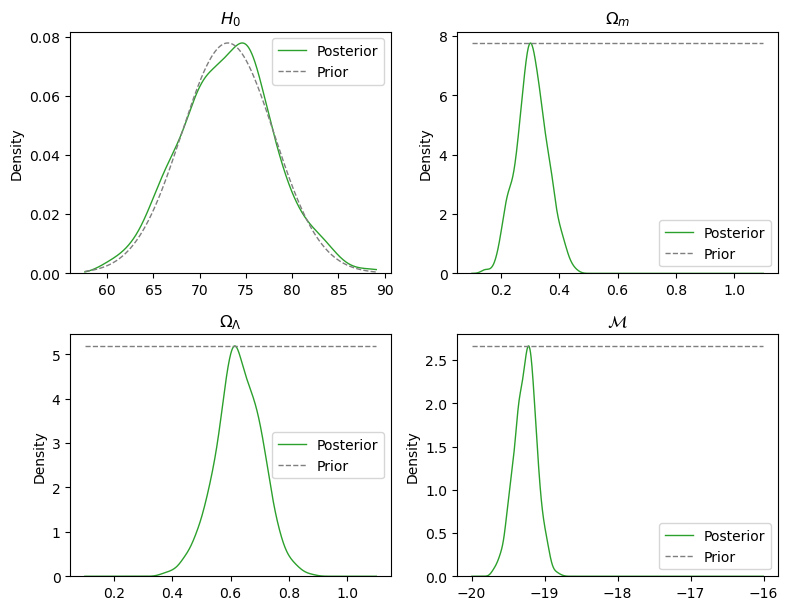

Substituting symbol M from STIXNonUnicode
Substituting symbol M from STIXNonUnicode


In [30]:
fig = create_prior_posterior_plots(chain_samples=chain_lcdm, prior_dists=[H_0_prior, Omega_m_prior, Omega_de_prior, M_prior], param_names=[r'$H_0$', r'$\Omega_m$',r'$\Omega_{\Lambda}$', r'$\mathcal{M}$'])
plt.show()

fig.savefig("plots/prior_vs_post_curved.svg")